# Assignment Module 2: Product Classification - PART 2

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Dict
import random
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
import pandas as pd

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.label_names = self.read_label_names()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def read_label_names(self) -> Dict[int, str]:
        label_names = {}
        with open(self.root / "classes.csv") as f:
            reader = csv.DictReader(f)
            for row in reader:
                class_id = int(row['Coarse Class ID (int)'])
                class_name = row['Coarse Class Name (str)']
                label_names[class_id] = class_name

        return label_names

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def get_label_name(self, label_idx: int) -> str:
        return self.label_names[label_idx]

## Fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

# Import dependencies

We will use in this project:

- WandBa: A tool designed to facilitate the tracking and visualizing of machine learning experiments.
- Torchmetrics: A library provided by PyTorch Lightning that simplifies the process of computing and logging machine learning metrics.

In [ ]:
!pip install -q wandb
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.1 MB/s eta 0:00:00


In [ ]:
!pip install tabulate

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import shutil
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F


from collections import defaultdict
from google.colab import drive
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, List, Optional

from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification.accuracy import Accuracy
from torchsummary import summary
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights, resnet18, ResNet18_Weights

In the next line, the User can set the USER NAME and the name of the WANDB project and typically analyze the graphs in a external window.

In [ ]:
import wandb

WANDB_USER = ""  # insert your wandb username here
WANDB_PROJECT = ""

# Reproducibility

We set a seed for various random number generators to ensure reproducibility of experiments

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

# Runtime settings

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings")

All good, a GPU is available


# 1 - FINE-TUNING THE RESNET-18

First, we choose a pre-train the model, in this case ResNet-18 pretrain on ImageNet-1K (V1) (consists of 1,000 classes, with each class containing hundreds to thousands of images. The classes correspond to various objects and scenes, such as animals, vehicles, household items, and more), which has been trained with classes containing products similar to the classes included in `GroceryStoreDataset`, this suggests Transfer Learning can be a good option to be implemented in our project

Then we will remove the original classifier and connect a new one.

After that, we will train only the new classifier on the new dataset while keeping the feature extractor unchanged during back-propagation (freezing);

Finally, we fine-tune the new network by unfreezing some parts of the pre-trained model and continuing training with the new dataset.

A summary of the main parts of the architecture of our model can be seen in the next image

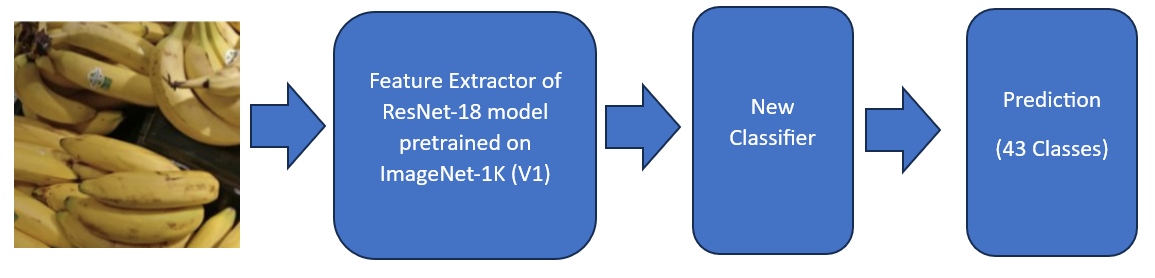

## Hyperparameters

As the assigments demands, we have to use the hyperparameters from CNN which performed the best in Assigment 2 Part 1. These are:

`resize_size` = 340

`batch_size` = 16

`num_epoch` = 59 (due to GPU power needed, we started from less epochs, 20 in this case)

learning rate `lr` = 0.0001

weight decay `wd`= 0.0001

optimizer: Adam

In [ ]:
cfg = {
    "resize_size": 340,
    "crop_size": 224,

    "batch_size": 16,
    "num_epochs": 20,

    "lr": 0.0001,
    "wd": 0.0001,
}

## Transfer Learning for Product Classification

The goal is to build a NN which will classify the classes of the Grocery Store Dataset, which contains the dataset of natural images of grocery items. All natural images was taken with a smartphone camera in different grocery stores.

`T.RandomResizedCrop`: Randomly crops the image to a size specified and then resizes it to the same size. This helps in data augmentation by creating random variations of the images, which can improve the robustness of the model.

`T.RandomHorizontalFlip():` Randomly flips the image horizontally with a probability of 0.5. This is another data augmentation technique that helps the model generalize better by learning from different orientations of the same image.

`T.CenterCrop()`: Crops the central part of the image to the size specified.

`T.ToTensor()`: Converts the image to a PyTorch tensor and scales the pixel values to the range [0, 1].

`T.Resize(])`: Resizes the shorter side of the image to the value specified. while maintaining the aspect ratio.

`T.Normalize`: Uses `mean_image_net` (means) and `std_image_net` (standard deviations) computed on ImageNet, these values are commonly used and taken from experiments on images of real world

In [ ]:
mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]

data_transforms = {
    "train": T.Compose([T.RandomResizedCrop(cfg["crop_size"]),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(mean_image_net, std_image_net)]),

    "val": T.Compose([T.Resize(cfg["resize_size"]),
                      T.CenterCrop(cfg["crop_size"]),
                      T.ToTensor(),
                      T.Normalize(mean_image_net, std_image_net)])
}
data_train = GroceryStoreDataset(split='train', transform=data_transforms["train"])
data_val = GroceryStoreDataset(split='val', transform=data_transforms["val"])


num_classes = data_train.get_num_classes()


print(f"# Train samples = {len(data_train)}")
print(f"# Val samples = {len(data_val)}")
print(f"Classes = {num_classes}")

# Train samples = 2640
# Val samples = 296
Classes = 43


We have for this project 2640 Train samples, 296 Validations samples and 43 Classes

We will try to visualize our data set with labels, to do that, we go back and inverse our transformations

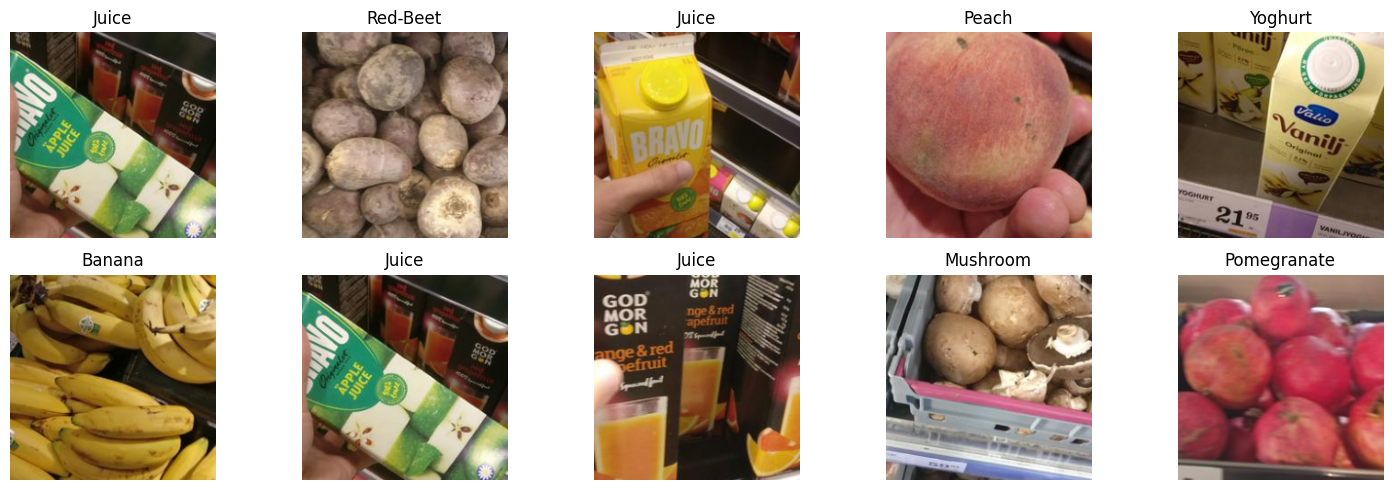

In [ ]:
class NormalizeInverse(T.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


def show_grid(dataset: ImageFolder, process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = data_train.get_label_name(dataset.__getitem__(idx)[1])
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(T.ToPILImage()(image_processed))
        plt.axis("off")

    plt.tight_layout()
    plt.show()


denormalize = NormalizeInverse(mean_image_net, std_image_net)
show_grid(data_val, process=denormalize)

DataLoader will help us to devide the Data Set in batches, creating an iterable over a dataset

In [ ]:
loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False
)

## Training functionalities

We define our Training loop,  It serves as a central component that coordinates the process of training a neural network

Adam as the Optimizer is used together with a Scheduler which experimentally works well.

In [ ]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = Adam(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)


        self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

## Apply Transfer Learning

Because our training dataset is small, the model trained on it doesn't achieve high accuracy. In such situations, transfer learning can be beneficial. We leverage a pre-trained feature extractor from the ImageNet dataset and then augment it with a new classifier.

The following image describe the architecture of ResNet-18

<img src = "https://forums.fast.ai/uploads/default/original/3X/f/9/f9a8eaaa866c2b783162fe65afdff67171e993fb.png" width = "400px" height="400px">



In the next function `get_model`, we define a new model `model`  based on resnet18 and we assigned weights to it.

We override the previous classifier with a new one (`nn.Linear()`) with the numbers of classes of `GroceryStoreDataset`.



In [ ]:
def get_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    # Here we override the old classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

To only train the classifier, the weights should be kept, shouldn't be changed, in order to do so, we set their `requires_grad` attribute to `False`:

In [ ]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

We "freeze" the weights of the layers inside the Feature Extractor in order to maintain the performance of it, and attach and train the newly created classifier.

We will use the weights obtained from the pretrained process on IMAGENET1K_V1, with `ResNet18_Weights.IMAGENET1K_V1`.

The different layers will be freeze by setting `False` in the method `set_requires_grad()`.

We can learn about the architecture of the Pytorch [implementation](https://github.com/pytorch/vision/blob/ab0b9a436bd64c4d0309f1b700868c2fe73c0f3e/torchvision/models/resnet.py#L166) of ResNet-18 in order to freeze specific layers.


In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
net_transfer = get_model(num_classes, weights).to(device)

set_requires_grad(net_transfer.conv1, False)
set_requires_grad(net_transfer.bn1, False)
set_requires_grad(net_transfer.layer1, False)
set_requires_grad(net_transfer.layer2, False)
set_requires_grad(net_transfer.layer3, False)
set_requires_grad(net_transfer.layer4, False)

summary(
    net_transfer,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.7MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

We can observe the name of our classifier "Linear-68" from the table, with a number of 43 classes and with **22059** trainable parameters.

We train our classifier, we are trying to "softly" adapt, transfer the knowledge from ResNet-18 to our set of `GroceryStoreDataset`.

In [ ]:
cfg["run_name"] = "resnet_transfer"

trainer = Trainer(
    net_transfer,
    loader_train,
    loader_val,
    device,
    num_classes
)
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

The results are showed in the following image:

The train/loss plot shows a decrease over time, which implies that the NN is learning and improving the weights over time.

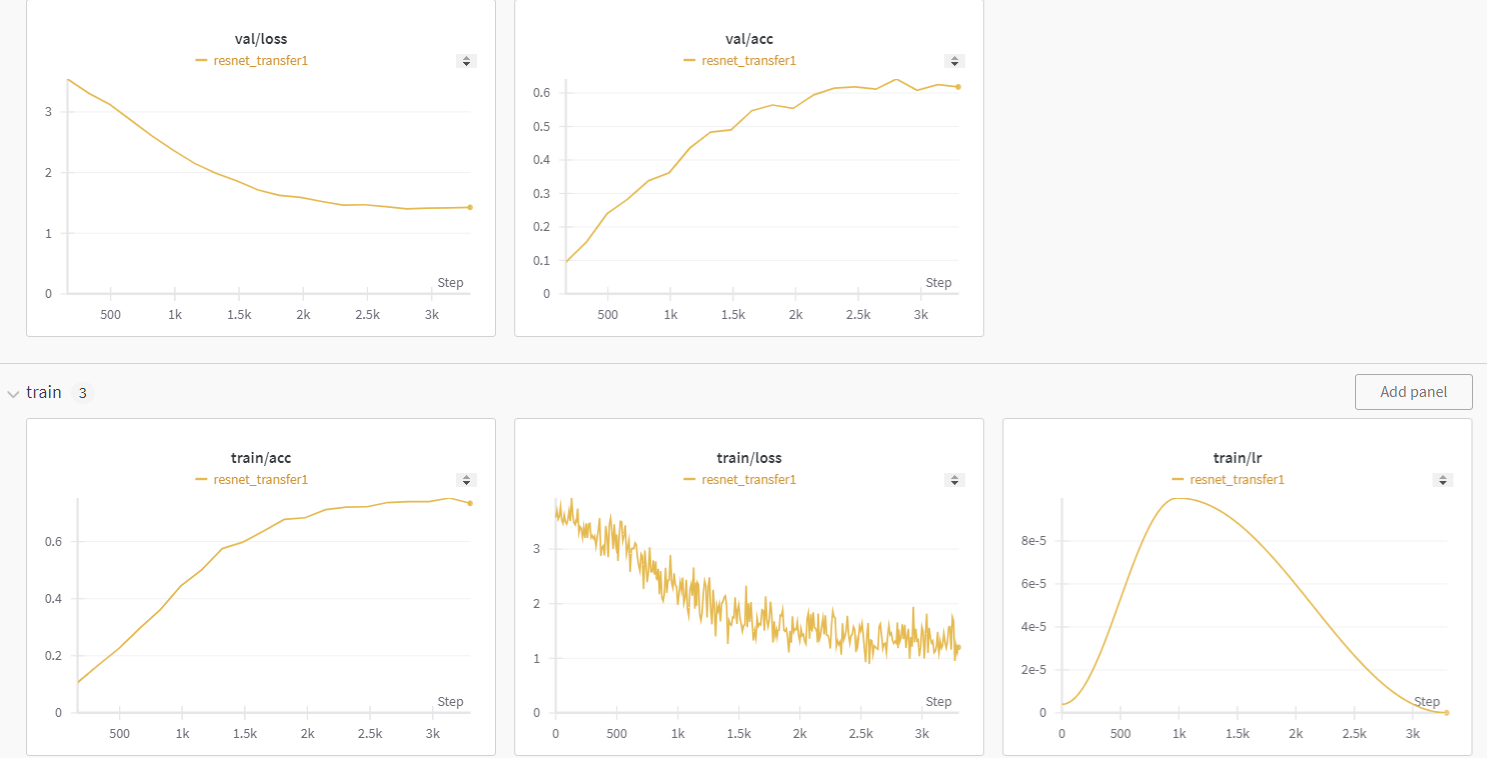

In [ ]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.642


From the training we have obtain a Validation Accuracy of **0.642**, which is a good number for the bunch of classes that we have. We will try to do it better by training the whole NN in the next step.



## Fine-tune the network

We didnt train the whole network with the new classifier because most of the gradients updates are determined by the classifier, which could have random values at the beginning and produce a lost of the information on the backbone

After training the classifier on the new dataset, we attempt to further refine the entire model by continuing training for a few epochs. This is typically done with a reduced learning rate (0.1*lr)

We will use the check points of the model with the best validation accuracy found on the last training by `torch.load()` and this time we set `set_requires_grad()` to `True` because now the backbone will be trained.

In [ ]:
sd = torch.load("ckpts/resnet_transfer.pt")
net_transfer.load_state_dict(sd)

set_requires_grad(net_transfer.conv1, True)
set_requires_grad(net_transfer.bn1, True)
set_requires_grad(net_transfer.layer1, True)
set_requires_grad(net_transfer.layer2, True)
set_requires_grad(net_transfer.layer3, True)
set_requires_grad(net_transfer.layer4, True)

In [ ]:
summary(
    net_transfer,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

From last table, it is observable that our trainable parameters this time is around **11.2 M**

We train the model again with the new Learning rate `lr` and the new reduced number of epochs `num_epochs`, as good practices suggest.

In [ ]:
cfg["run_name"] = "resnet_fine_tuning"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10

trainer = Trainer(
    net_transfer,
    loader_train,
    loader_val,
    device,
    num_classes
)
trainer.train()

wandb: Currently logged in as: ivanbarona1994 (ivanbarona1994-University of Bologna). Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

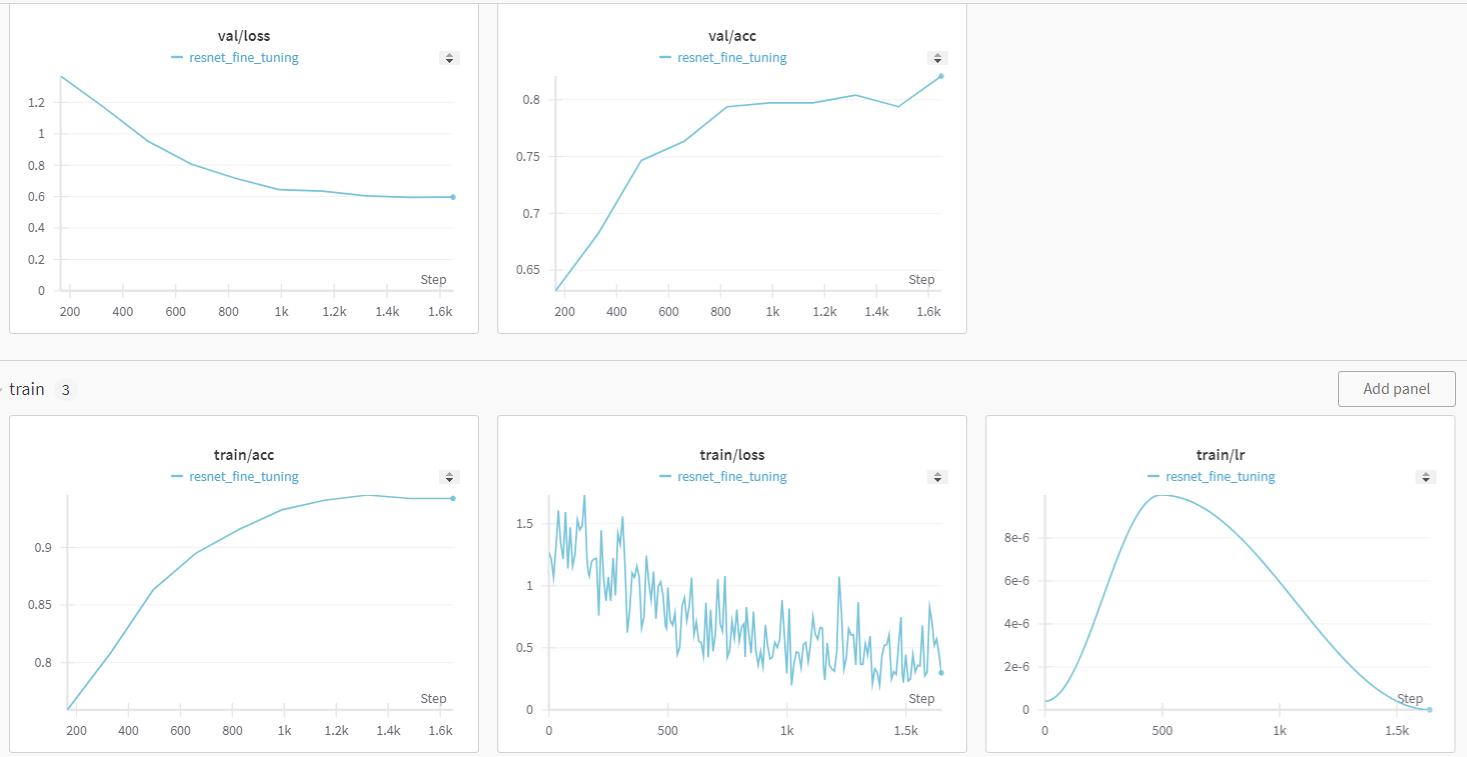

In [ ]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.821


This time the best accuracy was **82.1%, finally achieving the requirements of the assignment (80 to 90%).**

In the next picture we can see the performance of the two trainings, the retnet_fine_tuning (last training) plot has a lower train/loss at the end ot the the training and the.

Notice that the learning rate is smaller and was completed in less steps due to the number of epochs.

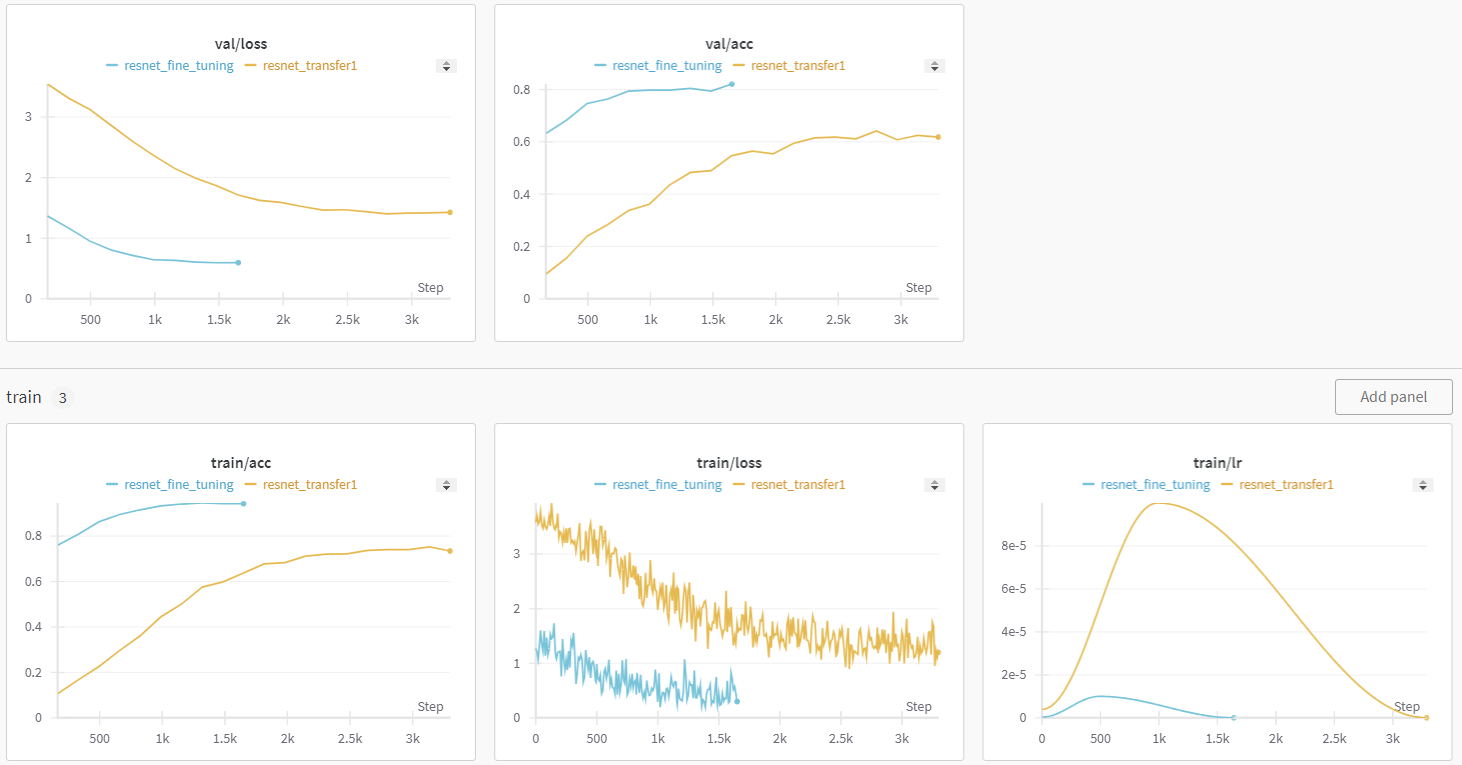

The next image (interactive with a button "Update Images"), shows some predictions of our model. We can observe the dismatches (text in red) between Predictions and True Label, meaning our model made a wrong prediction, however in all the cases the wrong predictions "make sense", for example Predicting: Satsumas intead of Oranges, is acceptable, because the color and shape of those fruits are quite similar.

Button(description='Update Images', style=ButtonStyle())

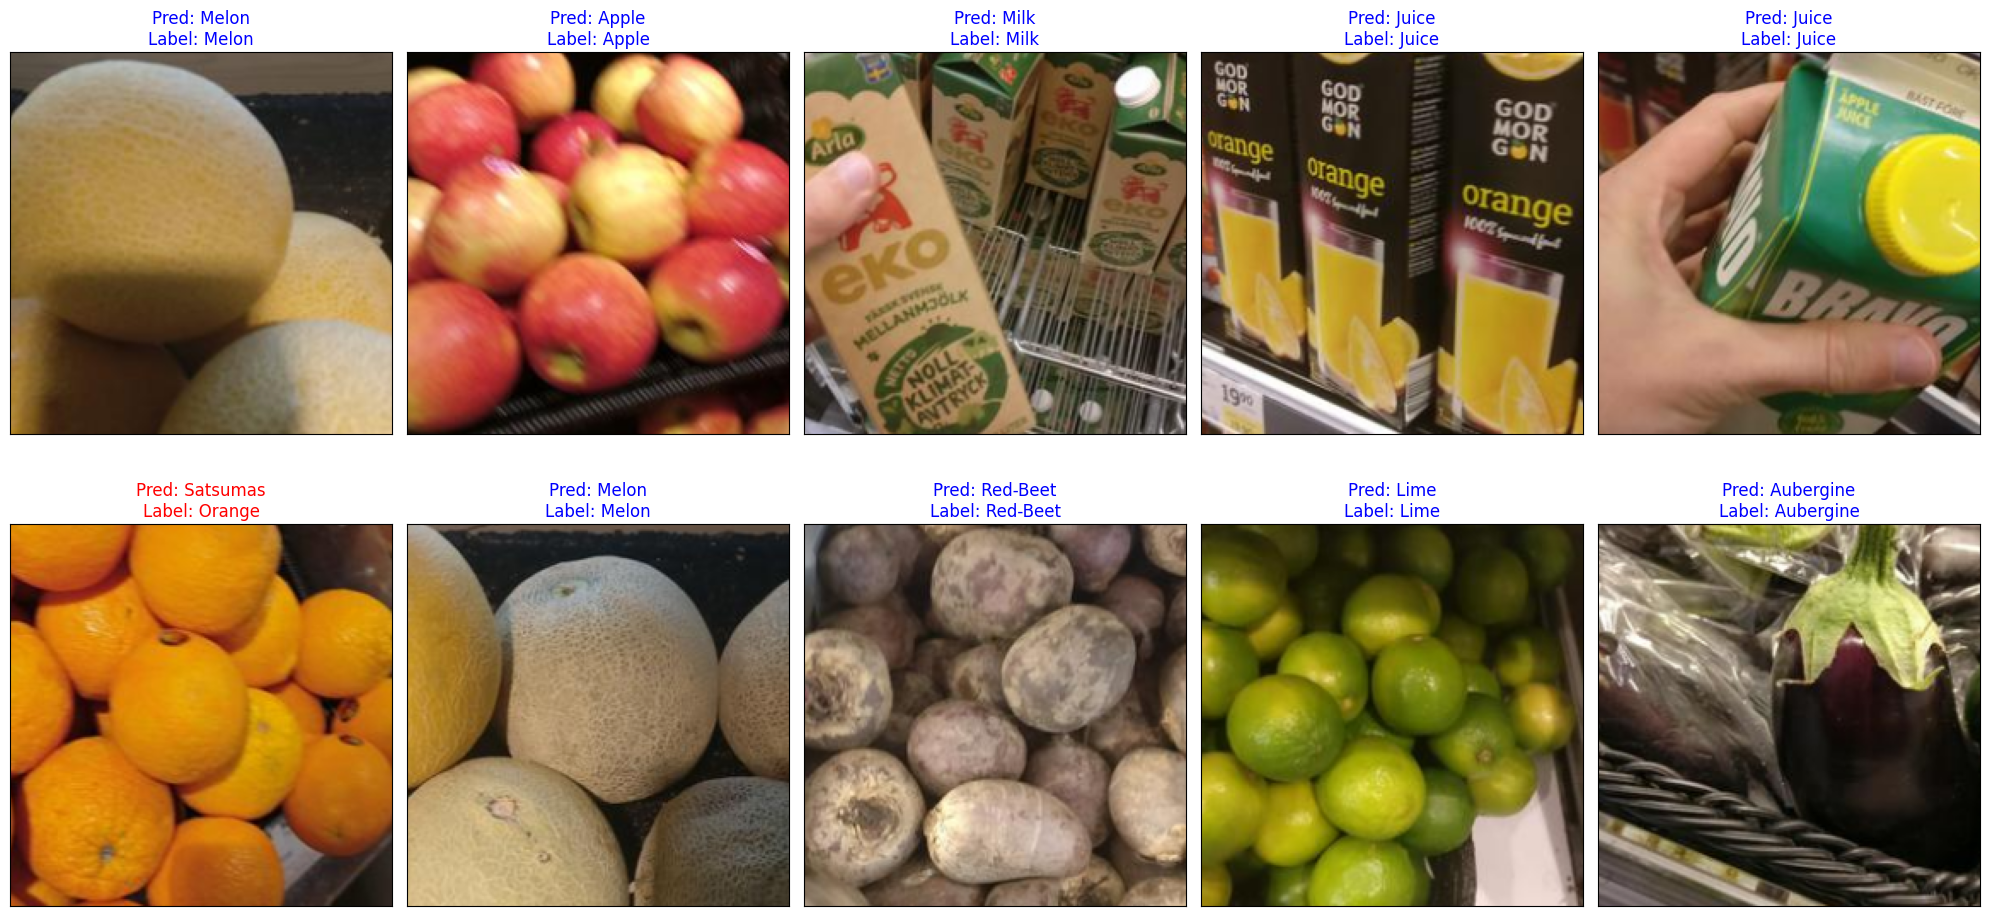

In [ ]:
#@title Show Predictions {run:"auto", display-mode:"form"}
# Function to show predictions
def show_predictions(change=None):
    net_transfer.eval()
    plt.figure(figsize=(20, 10))

    # Randomly select 10 indices
    indices = random.sample(range(len(data_val)), 10)

    for i, idx in enumerate(indices):
        image, label = data_val[idx]
        batch_image = image.unsqueeze(0)

        with torch.no_grad():
            output = net_transfer(batch_image.to(device))
            _, preds = torch.max(output, 1)

        ax = plt.subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(T.ToPILImage()(denormalize(image)))

        title = f"Pred: {data_train.get_label_name(preds[0].item())}\nLabel: {data_train.get_label_name(label)}"
        title_obj = ax.set_title(title)
        plt.setp(title_obj, color=("blue" if preds[0] == label else "red"))

    plt.tight_layout()
    clear_output(wait=True)
    display(update_button)
    plt.show()

# Creating the button widget
update_button = widgets.Button(description="Update Images")

# Linking the button to the update function
update_button.on_click(show_predictions)

# Display the button
display(update_button)

# Initial display
show_predictions()

# 2 - TUNING THE HYPERPARAMETERS

In the next steps, we will try to optimize our model, by using a hyperparameter Tuning technique, and try to find some specific hyperparameters that make the performance of the model better, in particular, which one can generate the max value of the accuracy in the Validation Set.

## Pick up the search method

We will use **Random Search** which chooses a random, uninformed, set of hyperparameter values.

Detailed information about this method can be found in this article, written by Gianluca Malato, [Hyperparameter Tuning](https://www.yourdatateacher.com/2021/05/19/hyperparameter-tuning-grid-search-and-random-search/)

When a model has several hyperparameters, identifying the optimal combination requires searching through a multi-dimensional space. This makes hyperparameter tuning, the process of finding the best hyperparameter values, both complex and time-consuming.

Here, we'll discuss two key algorithms for hyperparameter tuning:

**Grid Search**

Grid search is the most straightforward algorithm for hyperparameter tuning. It involves dividing the hyperparameters' domain into a discrete grid and then testing every possible combination of values on this grid. The combination of hyperparameter values that yields the highest average performance in cross-validation is considered the optimal set.

<div style="text-align: center;">
    <img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width="400px" height="400px">
    <p style="text-align: center;">Figure: Example of Grid Search, source <a href="https://www.yourdatateacher.com">Your Data Teacher</a>.</p>
</div>




**Random Search**

Random search operates similarly to grid search, but rather than evaluating every point in the grid, it examines only a randomly chosen subset of these points. A smaller subset results in quicker but less precise optimization, while a larger subset enhances accuracy, making it more comparable to a grid search.

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-7.png" width="400px" height="400px">

<p>Figure: Example of Random Search, source <a href="https://www.yourdatateacher.com">Your Data Teacher</a>.</p>

## Random Search Implementation

The program will take random values for the learning rate `lr`, `batch_size`, and weight decay `wd` by executing a random search.

A total number of experiments will be equal to 8, at the end the results of the best accuracy `best_acc` for each experiment will be compared and ordered

In [ ]:
# Define the parameter dictionary
parameters_dict = {
    "lr": [0.00001, 0.0001, 0.001, 0.01],
    "batch_size": [4, 8, 10, 12, 16],
    "wd": [0.00001, 0.0001, 0.001, 0.01],
}

# Example configuration
cfg = {
    "run_name": "",
    "num_epochs": 10,
}

best_results = []

num_experiments = 8  # Number of random experiments to perform

for i in range(num_experiments):

    sd = torch.load("ckpts/resnet_transfer.pt")
    net_transfer.load_state_dict(sd)

    set_requires_grad(net_transfer.conv1, True)
    set_requires_grad(net_transfer.bn1, True)
    set_requires_grad(net_transfer.layer1, True)
    set_requires_grad(net_transfer.layer2, True)
    set_requires_grad(net_transfer.layer3, True)
    set_requires_grad(net_transfer.layer4, True)

    # Randomly select parameter values
    cfg["lr"] = random.choice(parameters_dict["lr"])
    cfg["batch_size"] = random.choice(parameters_dict["batch_size"])
    cfg["wd"] = random.choice(parameters_dict["wd"])

    cfg["run_name"] = f"Experiment_{i+1}"  # Name to identify each experiment

    # Assuming Trainer class is imported correctly
    trainer = Trainer(
        net_transfer,  # Make sure net_transfer is correctly defined
        loader_train,
        loader_val,
        device,
        num_classes,
    )

    # Train the model
    trainer.train()

    # Save results of the current experiment
    experiment_result = {
        "run_name": cfg["run_name"],
        "lr": cfg["lr"],
        "batch_size": cfg["batch_size"],
        "wd": cfg["wd"],
        "best_val_acc": trainer.best_acc
    }
    best_results.append(experiment_result)

    # Print the best accuracy obtained in this experiment
    print(f"Experiment {i+1}: Best val acc = {trainer.best_acc:.3f}")




Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1: Best val acc = 0.811


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 2: Best val acc = 0.919


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 3: Best val acc = 0.922


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 4: Best val acc = 0.922


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 5: Best val acc = 0.818


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 6: Best val acc = 0.868


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 7: Best val acc = 0.926


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment 8: Best val acc = 0.824


In the next image we can observe the accuracy of the model in the validation set, we can see that the experiments with the best results are number 2,3,4 and 7.

The rest of the experiments present good results as well, but similar to the best value found after the Fine-Tune CNN which was 82.1%

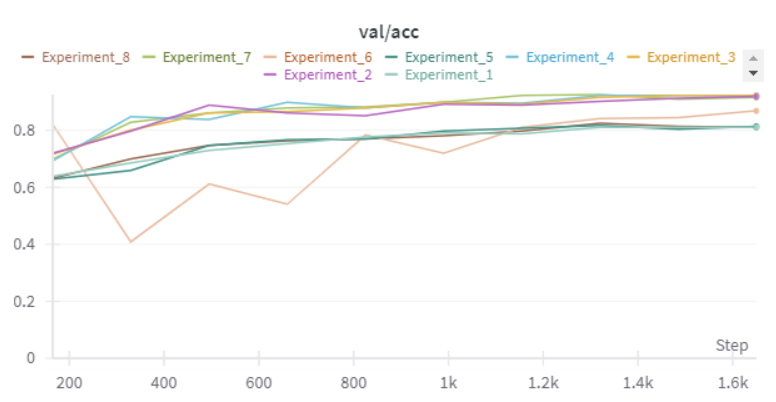

## Comparison table of results

In [ ]:
from tabulate import tabulate

# Create a DataFrame with the results
results_df = pd.DataFrame(best_results)

# Sort results by best validation accuracy descending
results_df = results_df.sort_values(by="best_val_acc", ascending=False)

# Display a comparative table of results using tabulate
print("\nComparative Table of Results:")
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Comparative Table of Results:
╒══════════════╤════════╤══════════════╤════════╤════════════════╕
│ run_name     │     lr │   batch_size │     wd │   best_val_acc │
╞══════════════╪════════╪══════════════╪════════╪════════════════╡
│ Experiment_7 │ 0.0001 │           10 │ 1e-05  │       0.925676 │
├──────────────┼────────┼──────────────┼────────┼────────────────┤
│ Experiment_3 │ 0.0001 │           16 │ 0.01   │       0.922297 │
├──────────────┼────────┼──────────────┼────────┼────────────────┤
│ Experiment_4 │ 0.0001 │           12 │ 0.001  │       0.922297 │
├──────────────┼────────┼──────────────┼────────┼────────────────┤
│ Experiment_2 │ 0.0001 │            8 │ 1e-05  │       0.918919 │
├──────────────┼────────┼──────────────┼────────┼────────────────┤
│ Experiment_6 │ 0.001  │           10 │ 0.0001 │       0.868243 │
├──────────────┼────────┼──────────────┼────────┼────────────────┤
│ Experiment_8 │ 1e-05  │           12 │ 1e-05  │       0.824324 │
├──────────────┼────────┼──────

The experiments indicate that the best performances are correlated to the value of the learning rate, which was 0.0001 (showing all of them a `best_acc` above 90%.

In particular our model can achieve an accuracy in the validation set of  **92.5%** with the parameters: `lr` = 0.0001, `batch_size`=10 and `wd`=1e-5

# CONCLUSION

We were able to optimize our model, going from an accuracy in the Validation Set of 64.2% after adding the new classifier and freezing the Feature extractor to an accuracy of 82.1% after Applying Fine Tuning and finally get a maximum value of the accuracy in the validation set of 92.5% after Hyperparameter Tuning with Random Search.